# Modules

Here we import the important modules of python that assist in the scientific programming purpose.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.sparse.linalg import gmres

# Functions
## Legendre polynomials
This function computes the Legendre Polynomials and its derivatives. The Legendre Polynomial in its recursive relation is given by

\begin{align*}
\phi_0(x)&=1 \\
\phi_1(x)&=x \\
\phi_N(x)&= \dfrac{2N-1}{N}x\phi_{N-1}(x)-\dfrac{N-1}{N}\phi_{N-2}(x)
\end{align*}
The firtst derivative of this function is
\begin{equation*}
\dfrac{d}{dx}\phi(x) = \dfrac{2N-1}{N} \left[ x\dfrac{d}{dx}\phi_{N-1}(x) + \phi_{N-1}(x) \right] - \dfrac{N-1}{N}\dfrac{d}{dx}\phi_{N-2}(x)
\end{equation*}
And the second derivative is
\begin{equation*}
\dfrac{d^2}{dx^2}\phi(x) = \dfrac{2N-1}{N} \left[ x\dfrac{d^2}{dx^2}\phi_{N-1}(x) + 2\dfrac{d}{dx}\phi_{N-1}(x) \right] - \dfrac{N-1}{N}\dfrac{d^2}{dx^2}\phi_{N-2}(x)
\end{equation*}

In [62]:
def legendre_polynomials(p, x):
    
    Pn=1
    Pnprime=0
    Pnpprime=0
    Pnminus1=0
    Pnminus1prime=0
    Pnminus1pprime=0

    for N in range(1,p+1):
        Pnminus2       = Pnminus1
        Pnminus2prime  = Pnminus1prime
        Pnminus2pprime = Pnminus1pprime
        Pnminus1       = Pn
        Pnminus1prime  = Pnprime
        Pnminus1pprime = Pnpprime
        Pn=(2*N-1)/N*x*Pnminus1 - (N-1)/N*Pnminus2
        Pnprime=(2*N-1)/N*(x*Pnminus1prime + Pnminus1) - (N-1)/N*Pnminus2prime
        Pnpprime=(2*N-1)/N*(x*Pnminus1pprime + 2*Pnminus1prime) - (N-1)/N*Pnminus2pprime

    return Pn, Pnprime, Pnpprime

## Legendre-Gauss-Lobatto points
### Lobatto Polynomials
It is given by the following formula
\begin{equation*}
\phi_N^{Lob}(x)= (1-x^2) \dfrac{d}{dx} \phi_{N-1}^{Leg}(x)  \qquad \forall \quad N \geq 2
\end{equation*}
### Quadrature Roots
The quadrature roots of the Lobatto Polynomials are found out using the Newton Raphson method as described above.
### Legendre-Gauss-Lobatto weights
The weights are given by the formula
\begin{equation*}
w_i = \dfrac{2}{N(N+1)\left(\phi_N (x_i)\right)^2}
\end{equation*}
where $x_i$ are the zeros of the Lobatto polynomials

In [63]:
def legendre_gauss_lobatto(P):

    N = P - 1                     # Order of Polynomials
    phalf = int(np.floor(P/2))    # Half number of points
    xlgl = np.zeros((P))           # Allocating memory for roots
    wlgl = np.zeros((P))           # Allocating memory for weights

    for i in range(phalf):
      x = np.cos(np.pi*(2*(i+1)-1)/(2*N+2))  # Initial guess for NR method
      for j in range(1,31):     # Newton Raphson method
          Pn, Pnprime, Pnpprime = legendre_polynomials(N,x)
          dx = -((1-x**2)*Pnprime)/((1-x**2)*Pnpprime - 2*x*Pnprime)
          x = x + dx
          if (abs(dx) < 1.0e-16):
            break
      xlgl[P-i-1] = x                        # Root of the polynomial   
      wlgl[P-i-1] = 2/(N*(N+1)*Pn**2)        # Weight of the polynomial 

    if (P != 2*phalf):   # Check for odd number of points
      x=0                # if yes then central root is zero
      Pn, _, _ = legendre_polynomials(N,x)
      xlgl[phalf] = x
      wlgl[phalf] = 2/(N*(N+1)*Pn**2)
      
    for i in range(phalf): # Calculating the other half roots as it is symmetric
      xlgl[i] = -xlgl[P-i-1]
      wlgl[i] = wlgl[P-i-1]
    return xlgl, wlgl

## Lagrange Basis Function
In this function, we calculate the Lagrange basis and its derivative, which are given by the following formulae
\begin{equation*}
L_i(x) = \prod_{j=0\;j\neq i}^{N} \dfrac{(x-x_j)}{(x_i-x_j)}
\end{equation*}

\begin{equation*}
\dfrac{d}{dx}L_i(x) = \sum_{j=0 \; j\neq i}^{N}\left(\dfrac{1}{x_i-x_j}\right) \prod_{k=0\;k\neq i\;k\neq j}^{N} \dfrac{(x-x_k)}{(x_i-x_k)}
\end{equation*}

In [64]:
def lagrange_basis(N,Q,xlg,xsample):

    phi=np.zeros((N,Q))
    phi2=np.zeros((N,Q))

    #Perform Quadrature/Sample the Function
    for l in range(Q):
        xl = xsample[l]
      
        #Construct Basis
        for i in range(N):
            xi = xlg[i]
            phi[i,l] = 1
            phi2[i,l] = 0
            for j in range(N):
                xj = xlg[j]
                #Basis
                if j != i:
                    phi[i,l] = phi[i,l] * (xl - xj)/(xi - xj)
                phi3 = 1
                if j != i:
                    for k in range(N):
                        xk = xlg[k]
                        #Derivative of Basis
                        if (k !=i and k !=j):
                            phi3 = phi3 * (xl - xk)/(xi - xk)
                    phi2[i,l] = phi2[i,l] + phi3/(xi - xj)
    return phi, phi2

## Create Grid

Here we create the 1D grid for the problem specified (CG or DG). Along with this, we also return integer matrices that tell us about the elemental end point continuity and periodicity vectors to check the elemental boundaries.

In [65]:
def grid(nlg, nelements, npoints_cg, npoints_dg, xlg):
    xmin = 0
    xmax = 10
    dx = (xmax - xmin) / nelements
    coordinates_cg = np.zeros(npoints_cg)
    coordinates_dg = np.zeros(npoints_dg)
    intma_cg = np.zeros((nelements, nlg))
    intma_dg = np.zeros((nelements, nlg))
    periodicity_cg = np.zeros(npoints_cg)
    periodicity_dg = np.zeros(npoints_dg)

    ip = 0
    coordinates_cg[0] = xmin
    for element in range(nelements):
        x0 = xmin + element*dx
        intma_cg[element,0] = ip
        for i in range(1,nlg):
            ip += 1
            coordinates_cg[ip] = (xlg[i] + 1)*dx/2 + x0
            intma_cg[element,i] = ip

    for i in range(npoints_cg):
        periodicity_cg[i] = i
    periodicity_cg[-1] = periodicity_cg[0]

    ip = 0
    for element in range(nelements):
        for i in range(nlg):
            intma_dg[element,i] = ip
            coordinates_dg[int(ip)] = coordinates_cg[int(intma_cg[element,i])]
            ip += 1

    for i in range(npoints_dg):
        periodicity_dg[i] = i
        
    return coordinates_cg, coordinates_dg, intma_cg, intma_dg, periodicity_cg, periodicity_dg

## Create M Matrix

The mass matrix in its physical space $x \in [x_0, x_1]$ and computational space $\xi \in [-1,+1]$ are
\begin{equation*}
M_{ij}^{(e)} = \int_{x_0}^{x_1} \psi_i(x) \psi_j(x)\;dx = \int_{-1}^{+1} \psi_i(\xi) \psi_j(\xi)\frac{dx}{d\xi} \; d\xi
\end{equation*}
In its discrete form, we can write
\begin{equation*}
M_{ij}^{(e)} =  \sum_{k=0}^{Q} w_k \psi_i(\xi_k) \psi_j(\xi_k) \frac{dx}{d\xi}
\end{equation*}

Here we also include the direct stiffness summation within the loop. We include the boundary conditions directly into the global matrix for CG method, whereas this is not done for DG.

In [66]:
def M_Matrix(intma, coordinates, npoints, nelements, N, Q, w, psi, iperiodic, method = "cg"):
    Mass = np.zeros((npoints,npoints))
    inode = np.zeros(N)
    x = np.zeros((N,1))

    for e in range(nelements):
        # Storing coordinates
        for i in range(N):
            x[i] = coordinates[int(intma[e,i])]
            inode[i] = iperiodic[int(intma[e,i])]
        # LGL Integration
        for k in range(Q):
            for i in range(N):
                for j in range(N):
                    Mass[int(inode[i]),int(inode[j])] += (x[N-1] - x[0])/2*w[k]*psi[i,k]*psi[j,k]
    
    # Implementing Dirichlet Boundary Conditions
    if method == "cg":
        Mass[0,:] = 0
        Mass[0,0] = 1
        Mass[-1,:] = 0
        Mass[-1,-1] = 1
    
    return Mass

## Create L Matrix


The Laplacian matrix in its physical space $x \in [x_0, x_1]$ and computational space $\xi \in [-1,+1]$ are
\begin{equation*}
L_{ij}^{(e)} = \int_{x_0}^{x_1} \frac{d \psi_i(x)}{dx} \frac{d \psi_j(x)}{dx}\;dx = \int_{-1}^{+1} \frac{d\psi_j(\xi)}{d\xi} \frac{d\psi_j(\xi)}{d\xi} \frac{d\xi}{dx} \; d\xi
\end{equation*}
In its discrete form, we can write
\begin{equation*}
L_{ij}^{(e)} =  \sum_{k=0}^{Q} w_k \frac{d\psi_i(\xi_k)}{d\xi} \frac{d\psi_j(\xi_k)}{d\xi} \frac{d\xi}{dx}
\end{equation*}

Here we also include the direct stiffness summation within the loop. For CG method, the boundary conditions are directly included into the global matrix, whereas for DG method, it is not included. There is an alternative formula for DG Laplacian and the present one is applicable for CG only

In [67]:
def L_Matrix(intma, coordinates, npoints, nelements, N, Q, w, dpsi, iperiodic):
    L = np.zeros((npoints, npoints))
    inode = np.zeros(N)
    x = np.zeros((N,1))

    for e in range(nelements):
        # Storing coordinates
        for i in range(N):
            x[i] = coordinates[int(intma[e,i])]
            inode[i] = iperiodic[int(intma[e,i])]
        # LGL Integration
        for k in range(Q):
            for j in range(N):
                for i in range(N):
                    L[int(inode[i]),int(inode[j])] += 2/(x[N-1] - x[0])*w[k]*dpsi[i,k]*dpsi[j,k]
    
    # Implementing Dirichlet Boundary Conditions
    L[0,:] = 0
    L[0,0] = 1
    L[-1,:] = 0
    L[-1,-1] = 1
    
    return L

## Create D Matrix

The Differentiation matrix for CG in its physical space $x \in [x_0, x_1]$ and computational space $\xi \in [-1,+1]$ are
\begin{equation*}
D_{ij}^{(e)} = \int_{x_0}^{x_1} \psi_i(x) \frac{d \psi_j(x)}{dx}\;dx = \int_{-1}^{+1} \psi_i(\xi)\left( \frac{d\psi_j(\xi)}{d\xi} \frac{d\xi}{dx} \right)\frac{dx}{d\xi} \; d\xi
\end{equation*}
In its discrete form, we can write
\begin{equation*}
D_{ij}^{(e)} =  \sum_{k=0}^{Q} w_k \psi_i(\xi_k) \frac{d\psi_j(\xi_k)}{d\xi}
\end{equation*}
Similarly for DG, it is
\begin{equation*}
D_{ij}^{(e)} =  \sum_{k=0}^{Q} w_k  \frac{d\psi_i(\xi_k)}{d\xi} \psi_i(\xi_k)
\end{equation*}
We also consider the Direct Stiffness Summation within the loop

In [68]:
def D_Matrix(intma, npoints, nelements, N, Q, w, psi, dpsi, iperiodic):
    Element_Diff = np.zeros((npoints, npoints))
    inodetwo = np.zeros(N)
    
    for e in range(nelements):
        # Storing coordinates
        for i in range(N):
            inodetwo[i] = iperiodic[int(intma[e,i])]
        # LGL Integration
        for k in range(Q):
            for j in range(N):
                for i in range(N):
                    Element_Diff[int(inodetwo[i]),int(inodetwo[j])] += w[k]*dpsi[i,k]*psi[j,k]

    return Element_Diff

## Flux Matrix

It is important to calculate the numerical flux in DG as it conveys information from one element to the other
### Centered Flux
This flux is given by
\begin{equation*}
f^{(\ast)} = \frac{1}{2} \left( f^{(e)} + f^{(l)} \right)
\end{equation*}
### Upwind Flux
This flux is given by the Rusanov numerical flux, where the outward pointing vector is positive.
\begin{equation*}
f^{(\ast,l)} = \frac{1}{2} \left[ f^{(e)} + f^{(l)} - n_l u (q^{(l)} - q^{(e)})\right]
\end{equation*}

In [69]:
def F_Matrix(intma, nelements, npoints, N, Flux = "upwind"):
    FluxMatrix = np.zeros((npoints, npoints))

    for e in range(nelements):
        I = int(intma[e,0])
        Im = I
        if (Im < 1):
            Im = npoints
        if Flux == "centered":
            FluxMatrix[I,Im-1] = -0.5
            FluxMatrix[I,I] = -0.5
        else:
            FluxMatrix[I,Im-1] = -1
        I = int(intma[e,N-1])
        Ip = I + 1
        if (Ip > npoints-1):
            Ip = 0
        if Flux == "centered":
            FluxMatrix[I,Ip] = 0.5
            FluxMatrix[I,I] = 0.5
        else:
            FluxMatrix[I,I] = 1
    
    return FluxMatrix

## Exact Solution

The problem at hand considers the elliptic equation of a temperature field, given by

\begin{equation*}
\dfrac{\partial^2 T}{\partial x^2} = -10
\end{equation*}
where T(0) = T(10) = 0
The analytical solution to this problem is
\begin{equation*}
T = -5x^2 +50x
\end{equation*}

In [70]:
def exact_solution(coordinates, npoints, fx):
    qexact = np.zeros(npoints)
    fexact = fx * np.ones(npoints)
    # fexact = np.zeros(npoints)
    # c = np.pi*2

    for i in range(npoints):
        #qexact[i] = np.sin(c*coordinates[i])
        #fexact[i]=-c**2*np.sin(c*coordinates[i])
        qexact[i] = -5*coordinates[i]**2 + 50*coordinates[i]
    return qexact, fexact

# Main Code
## Inputs

In [71]:
Nelements = np.array([[16,32,64],[4,8,16],[2,4,8],[1,2,4]])    #  number of elements             np.array([[16]]) #
N = [1, 4, 8, 16]                                               # Order of interpolation         [4]#
fx = -10                                                        # f(x)
integration_types = [0,1]                                       # =0 is exact and =1 is inexact  [0] #
method_types = ['cg','dg']                                      #  CG or DG                      ['dg']#
flux_type= 'centered' 

## Calculations

The laplacian for CG is directly used from the previous section. For DG it is calculated as follows
\begin{equation*}
L = \hat{D}M^{-1}\hat{D}
\end{equation*}
Where $\hat{D} = F_{IJ} - D_{IJ}$

This matrix is then used to calculate the result, given as
\begin{equation*}
L_{IJ} q_J = M_{IJ}f_J
\end{equation*}

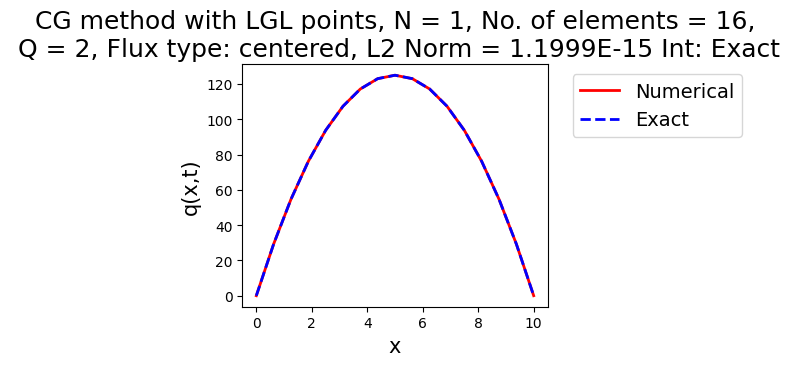

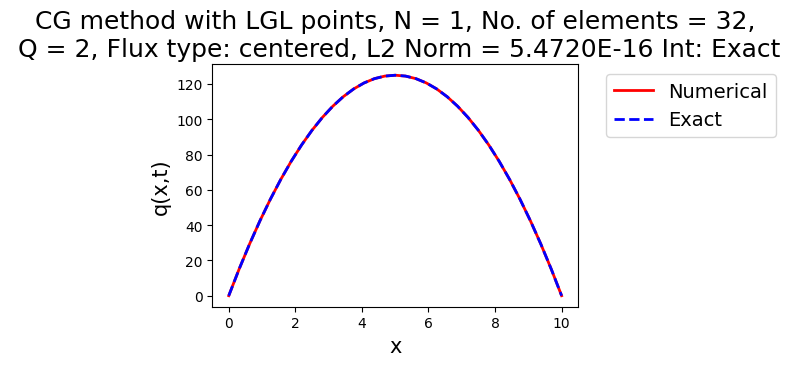

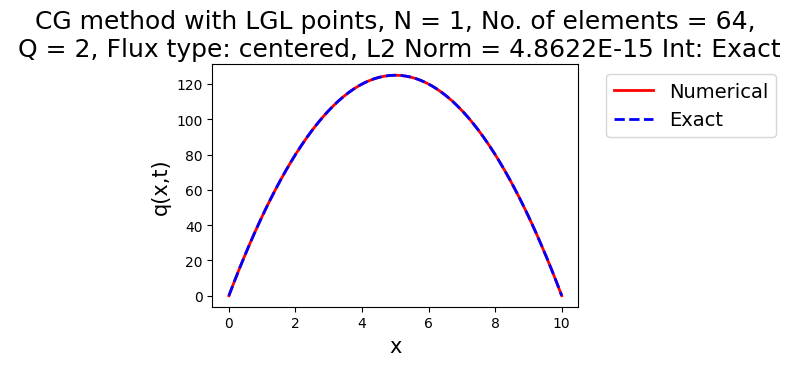

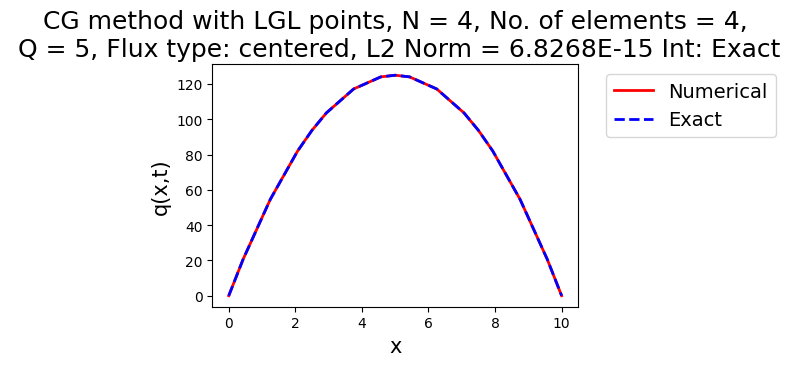

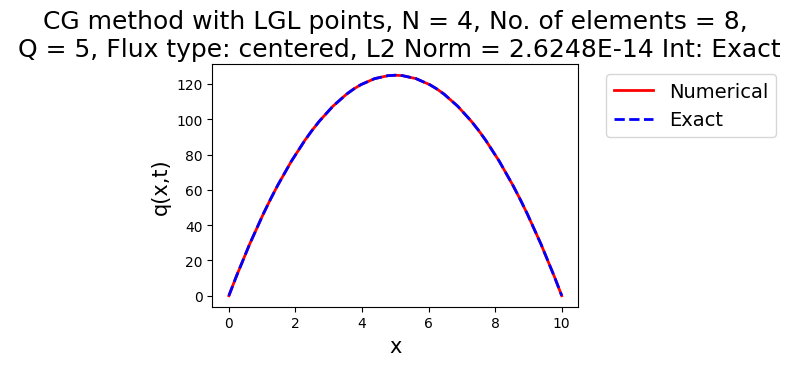

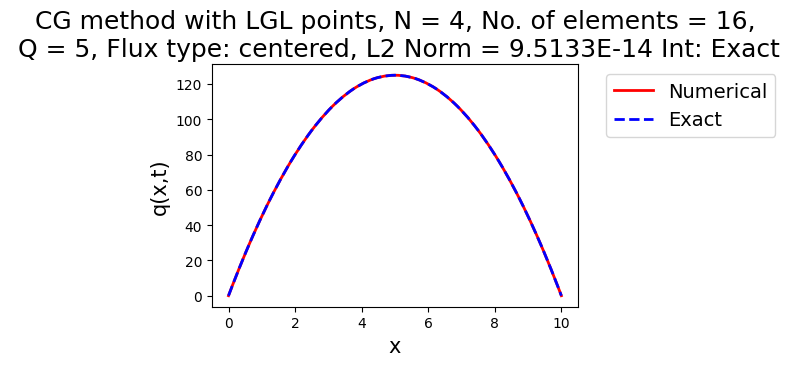

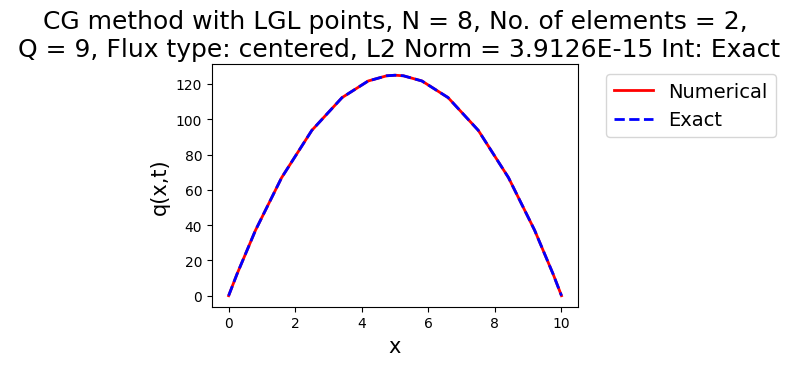

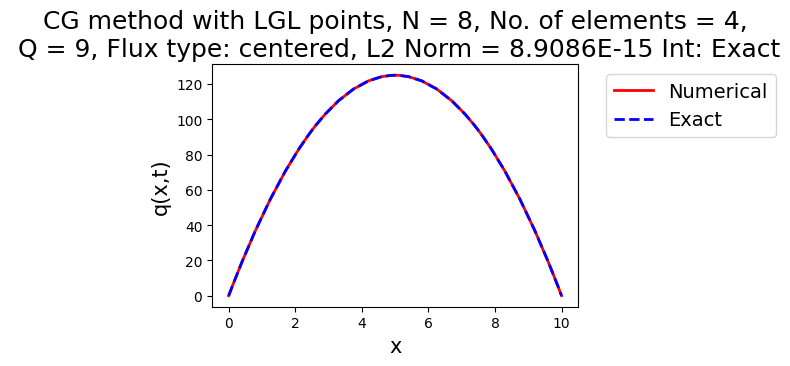

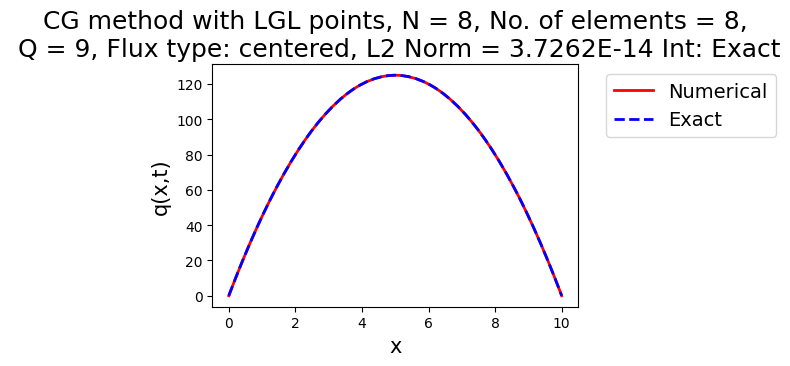

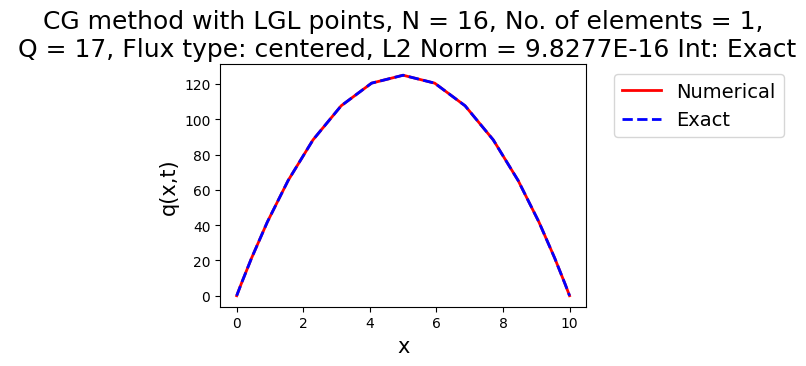

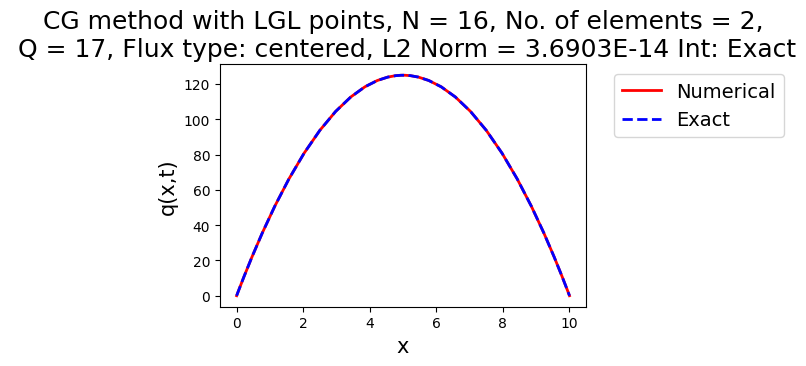

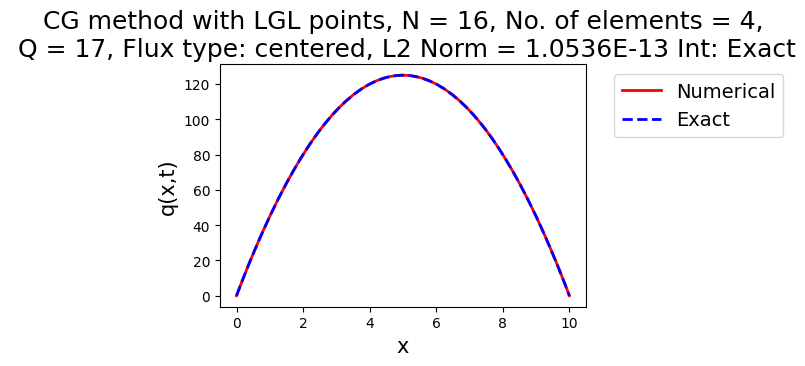

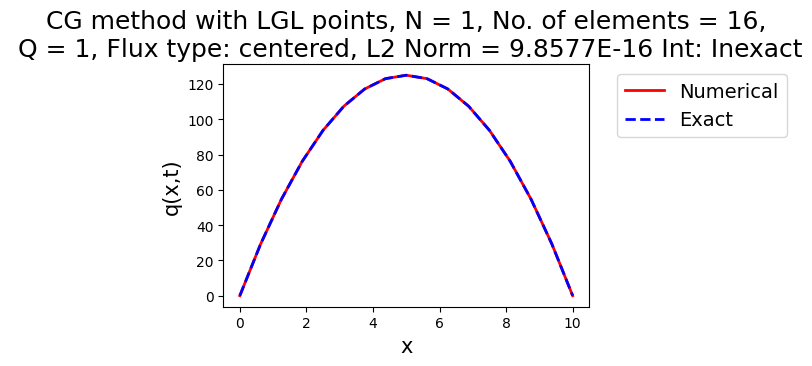

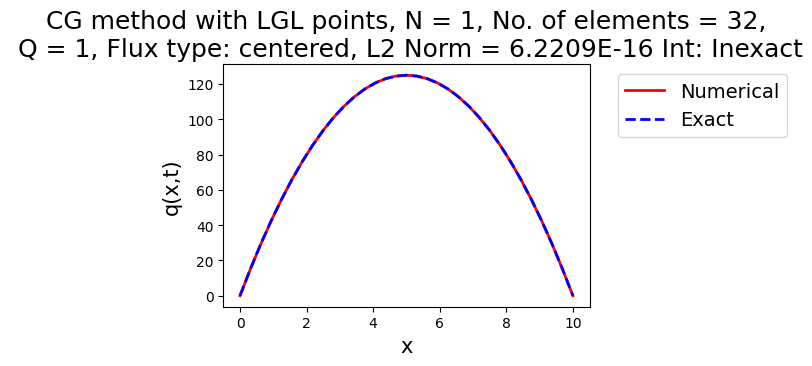

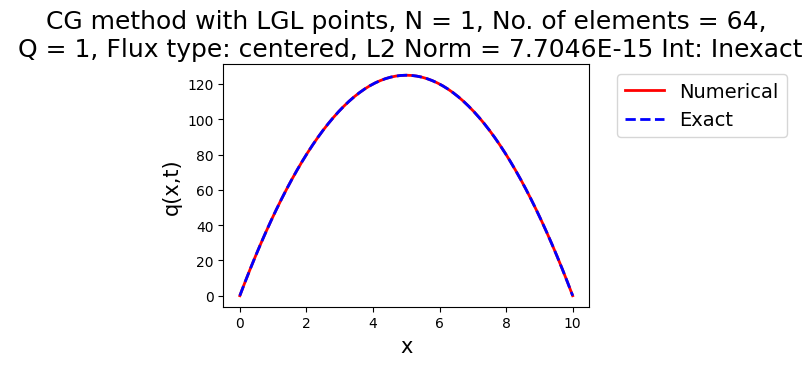

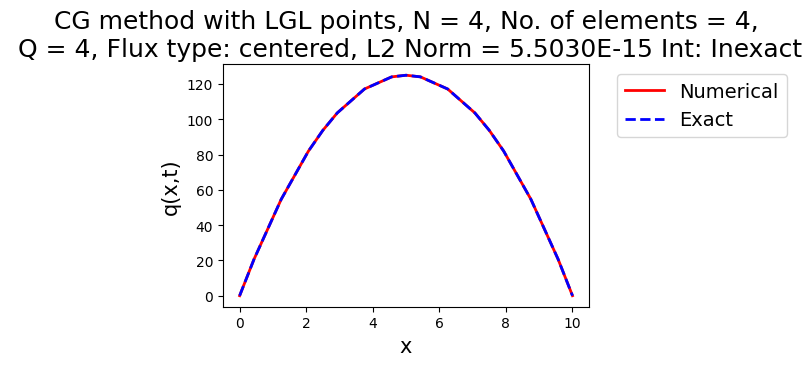

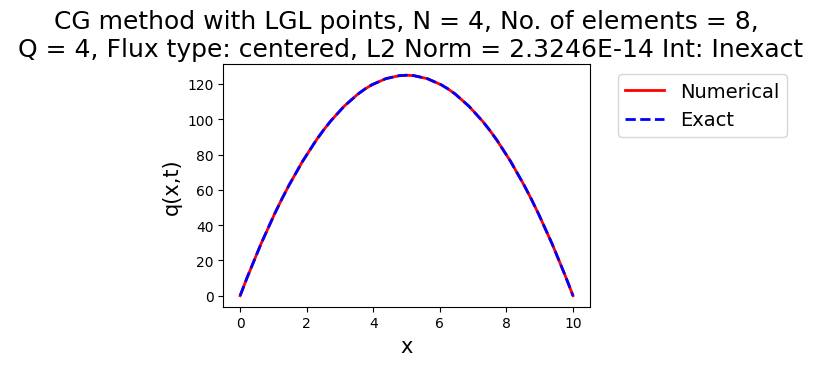

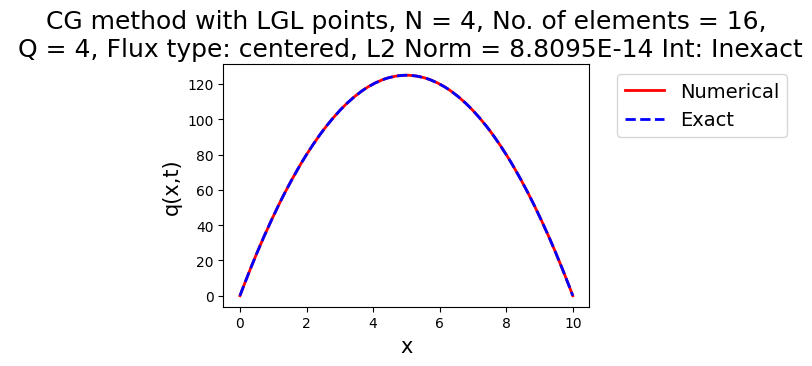

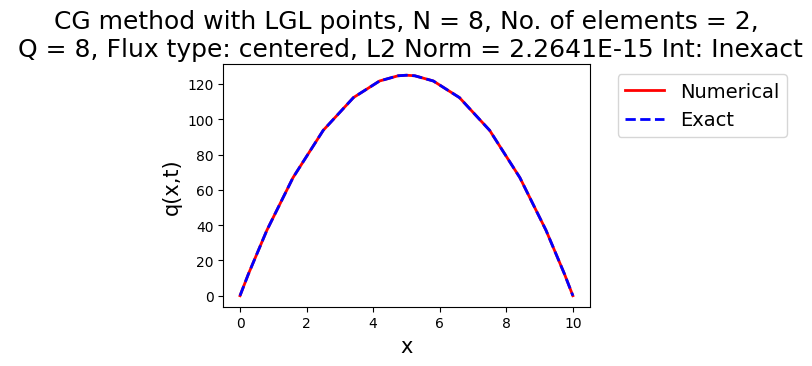

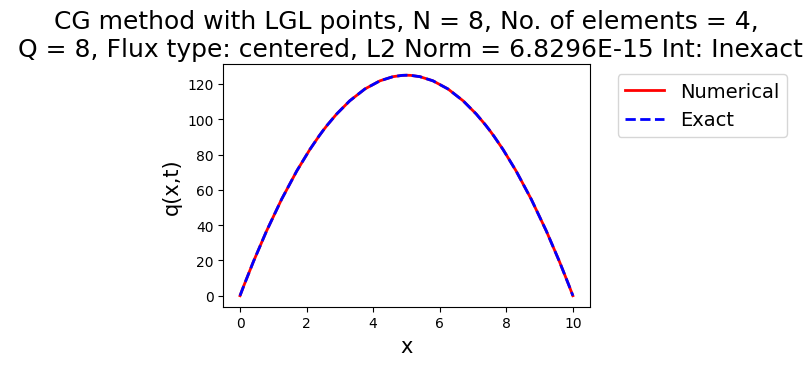

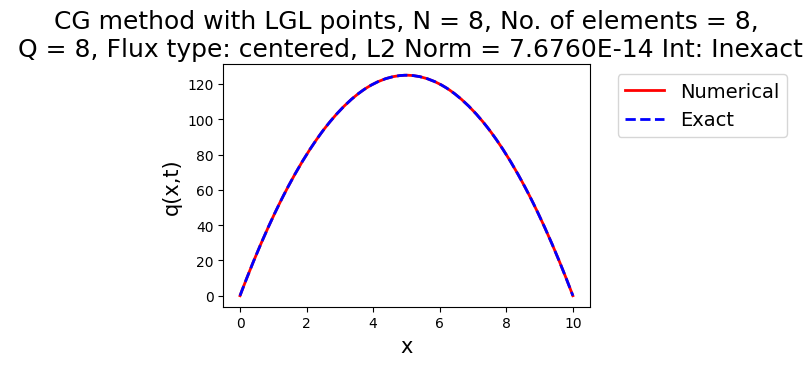

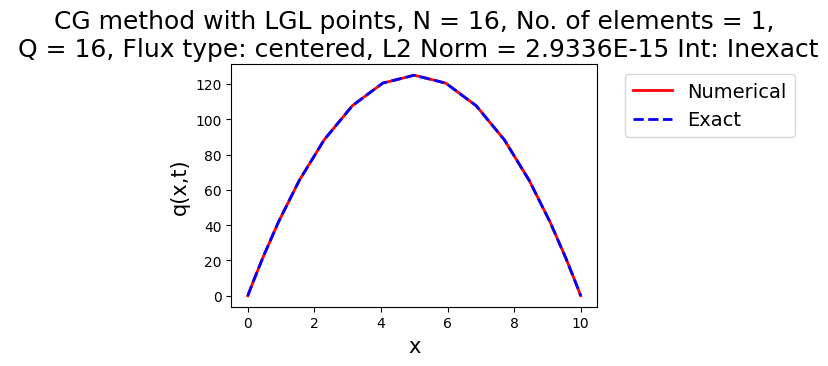

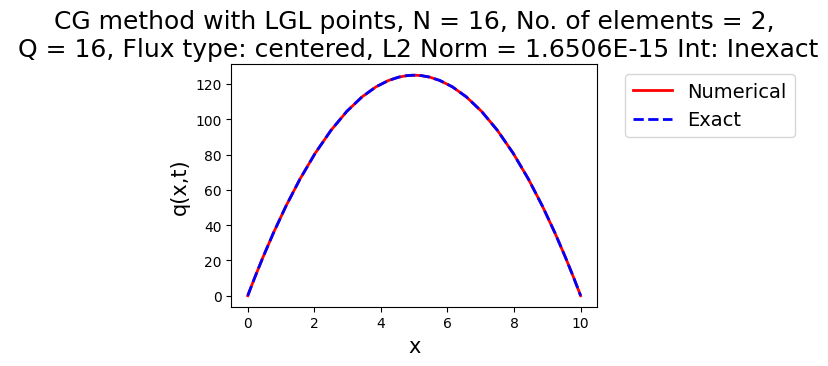

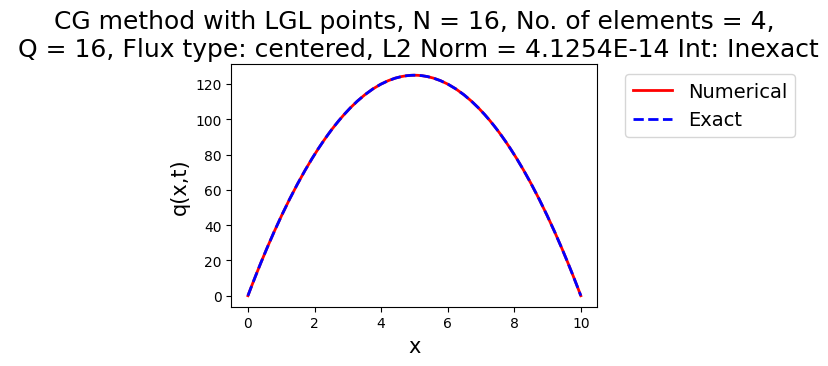

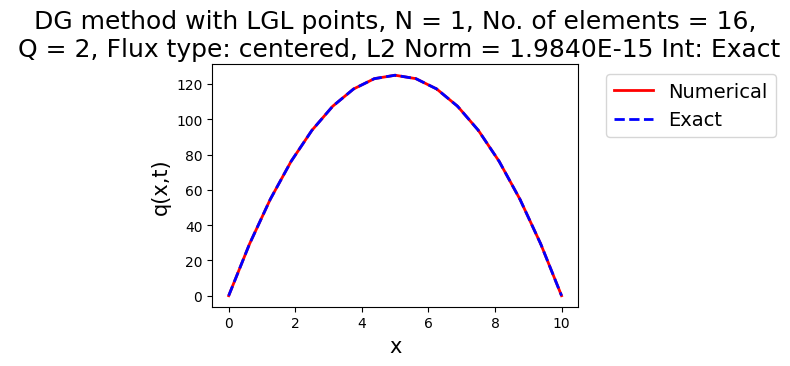

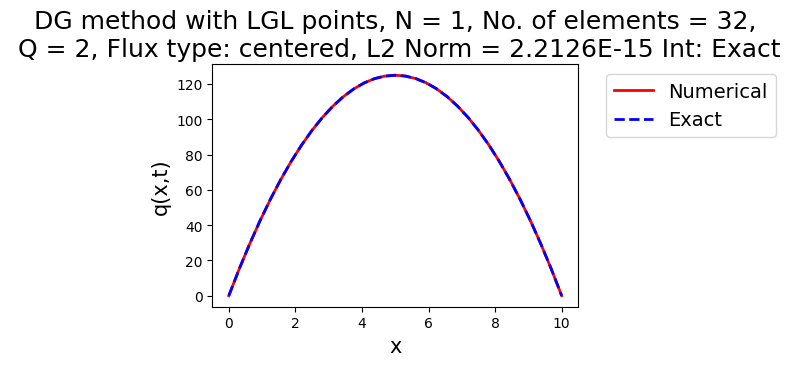

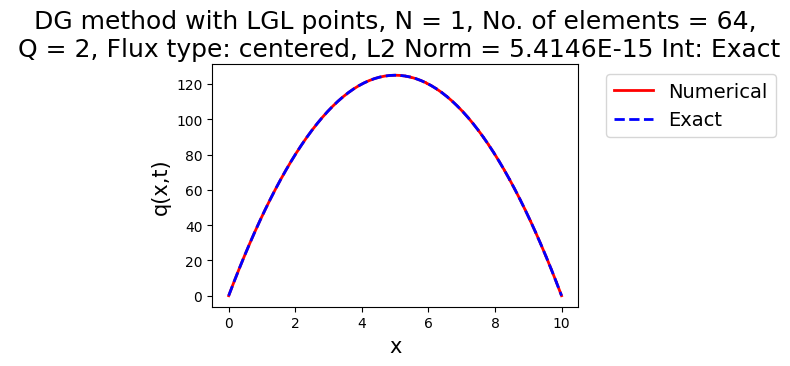

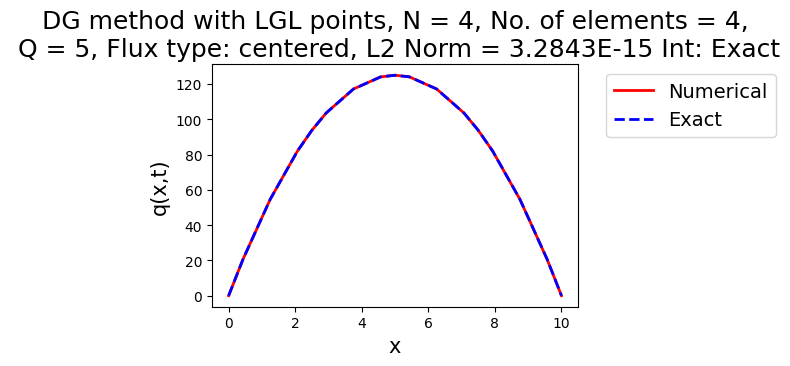

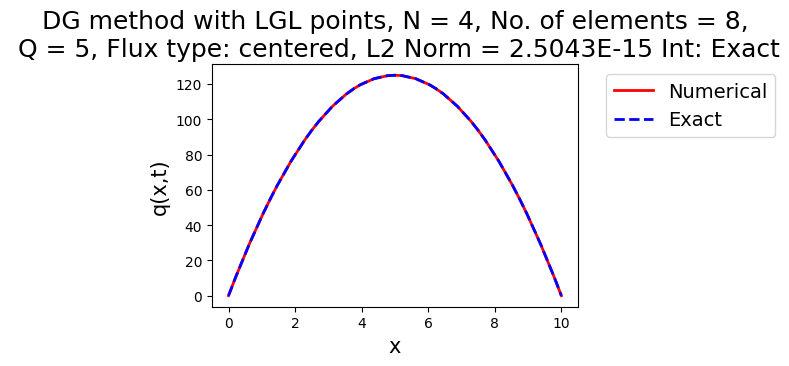

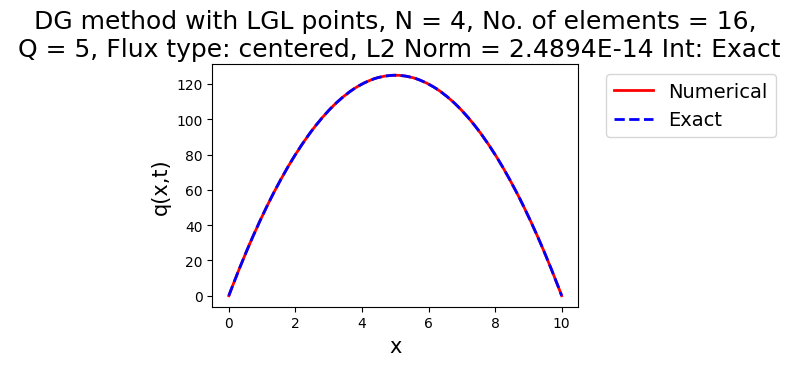

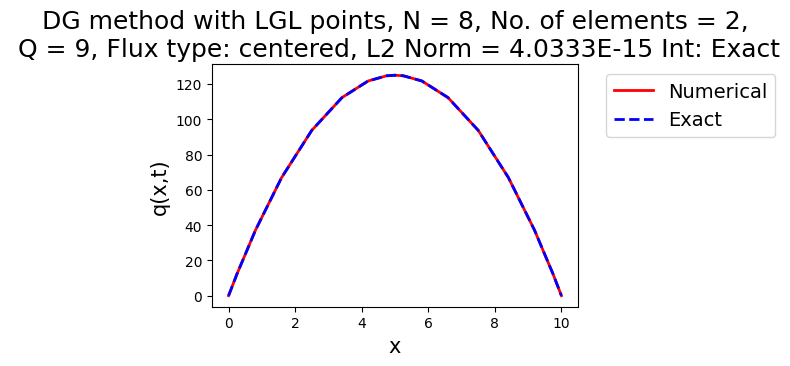

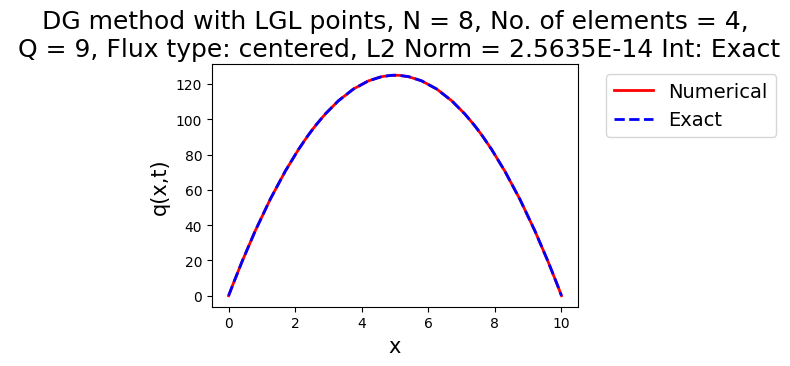

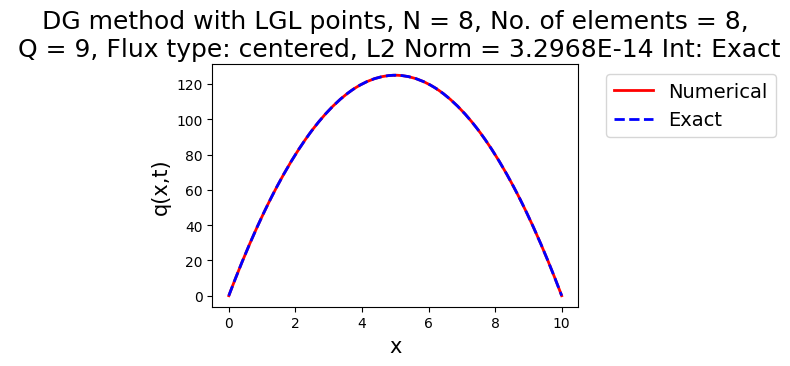

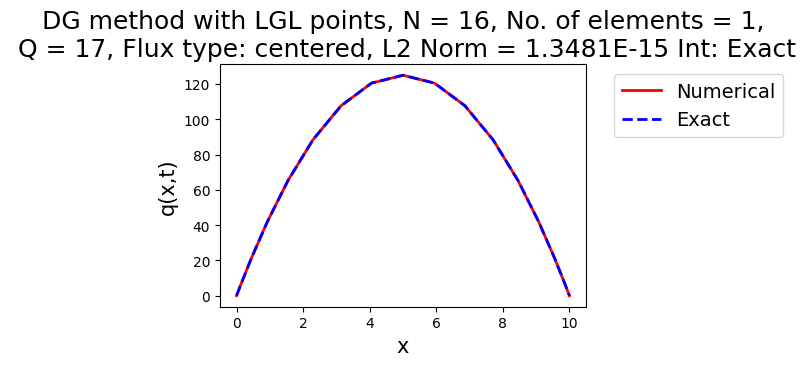

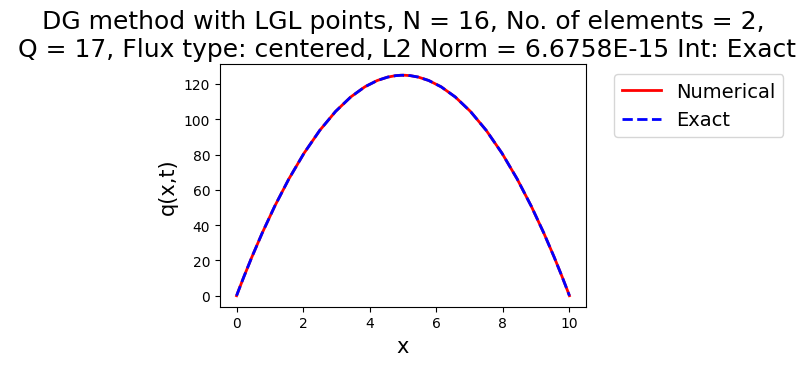

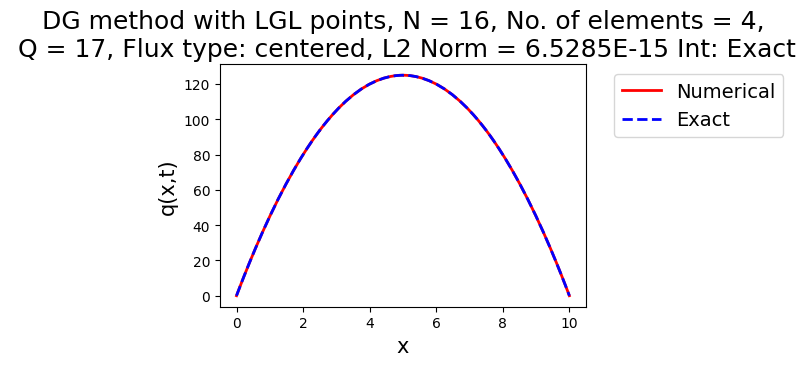

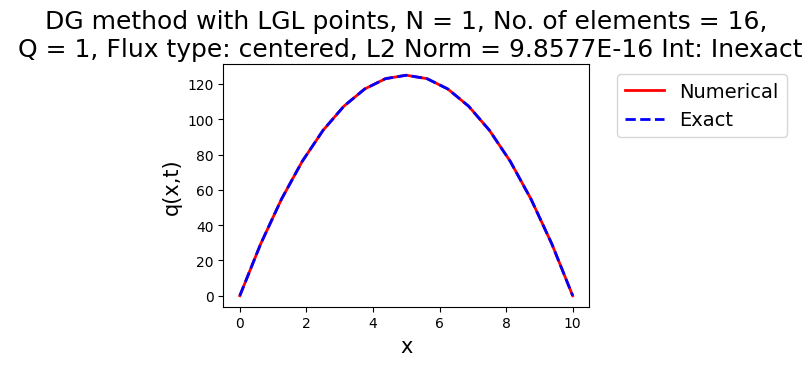

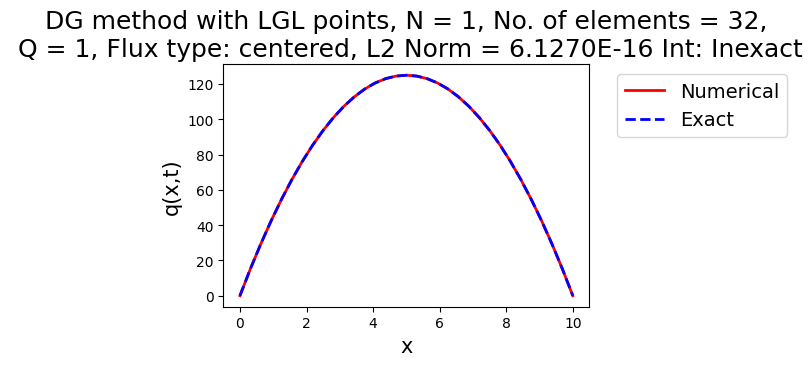

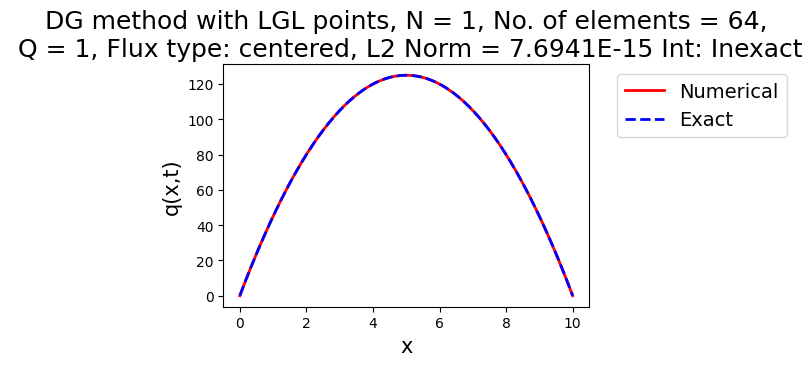

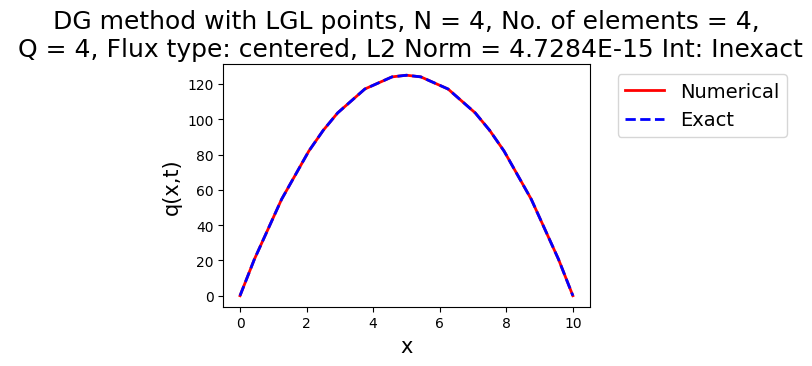

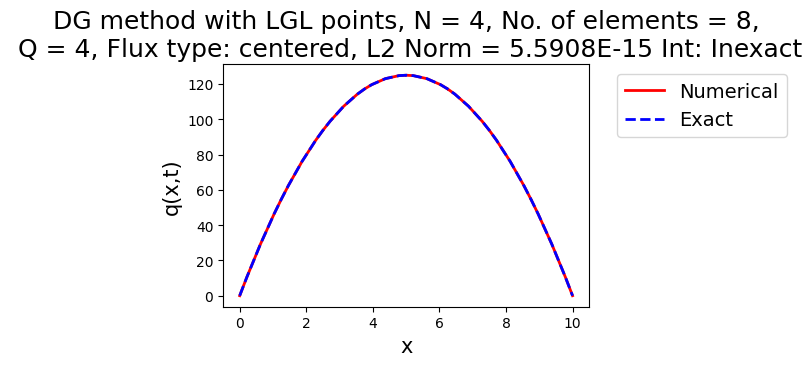

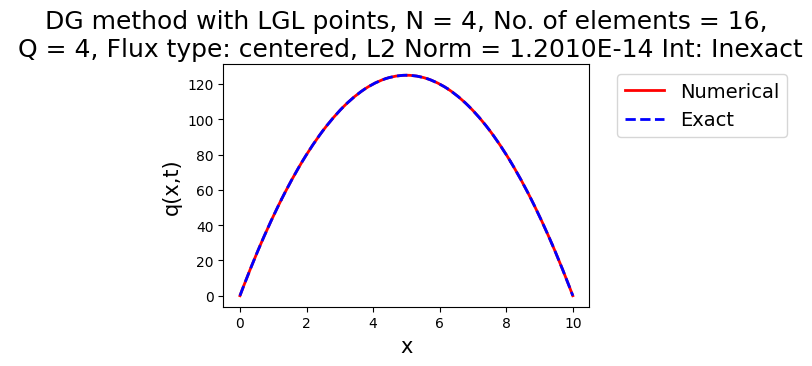

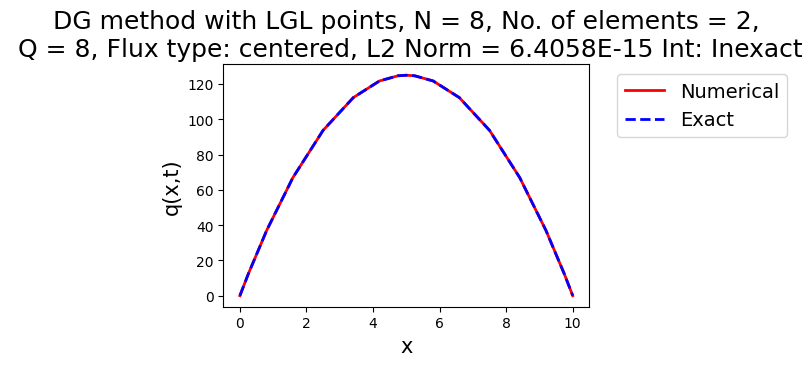

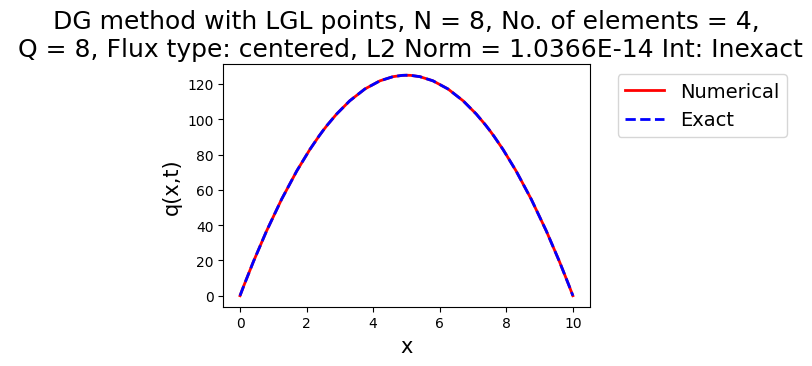

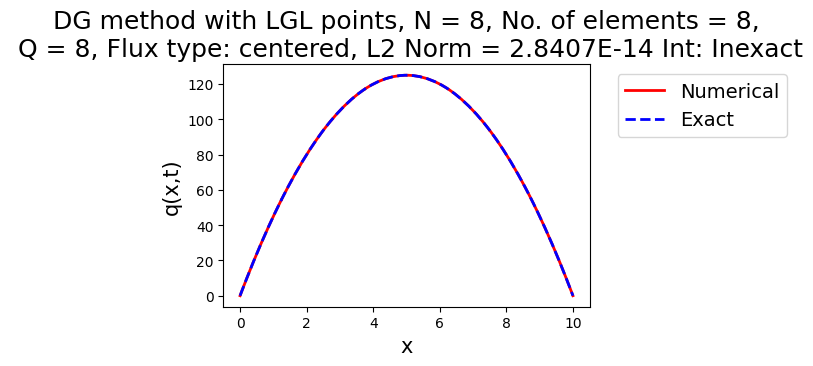

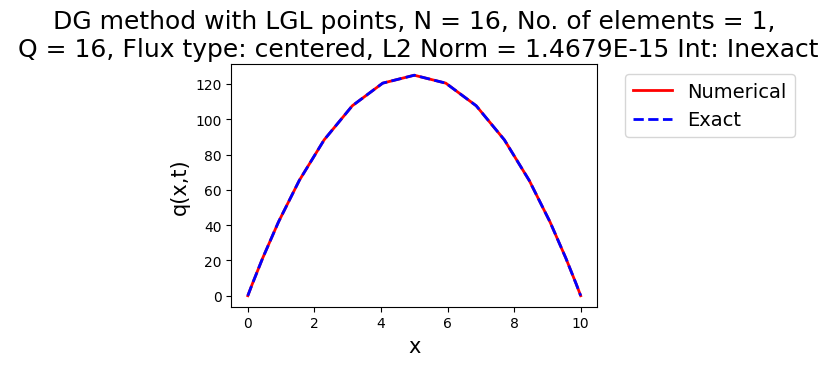

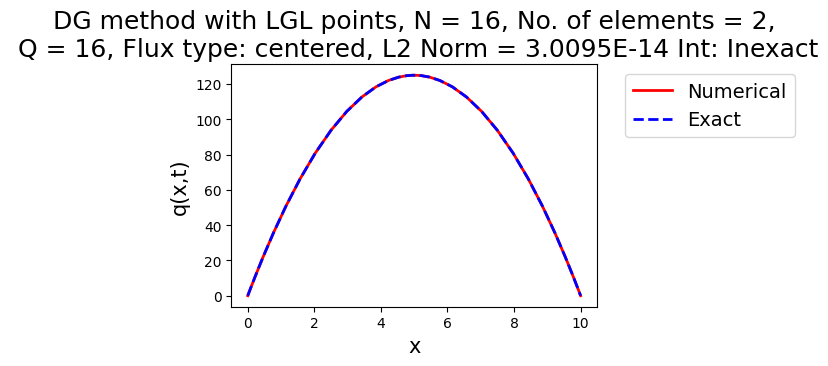

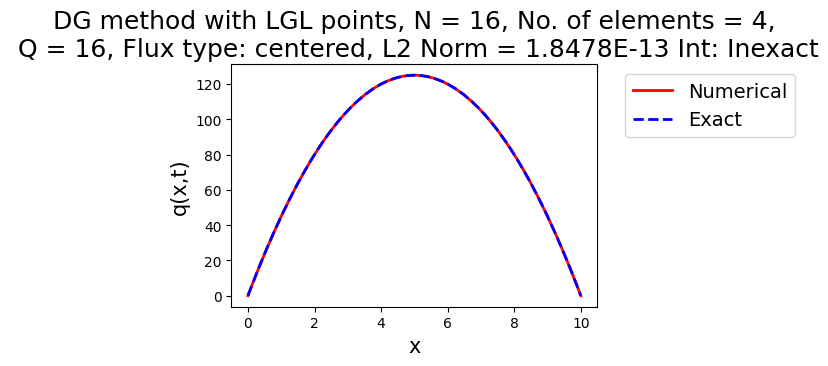

In [72]:
Normstore = np.zeros((12,2,2,2))    # Norms/Np, <-column_store, int_type, method
for method in method_types:
    for int_type in integration_types:
        for y in range(len(N)):
            for z in range(len(Nelements[0])):
                Nlg = N[y] + 1
                Npoints_CG = N[y] * Nelements[y,z] + 1
                Npoints_DG = Nlg * Nelements[y,z]
                if int(int_type) == 0:
                    Np = N[y] + 1                # Exact Integration
                    inttext = 'Exact'
                else:
                    Np = N[y]                   # Inexact Integration
                    inttext = 'Inexact'
                Nq = Np + 1

                # LGL Points calculation
                xlg, wlg = legendre_gauss_lobatto(Nlg)
                xnq, wnq = legendre_gauss_lobatto(Nq)

                # Lagrange Polynomials and its derivatives
                psi, dpsi = lagrange_basis(Nlg, Nq, xlg, xnq)
                psi = np.array(psi)
                dpsi = np.array(dpsi)

                # Grid generation
                coordinates_cg, coordinates_dg, intma_cg, intma_dg, periodicity_cg, periodicity_dg = grid(Nlg, Nelements[y,z], Npoints_CG, Npoints_DG, xlg)

                # Storing values
                if method == 'cg':
                    Npoints = Npoints_CG
                    coordinates = coordinates_cg
                    intma = intma_cg
                    periodicity = periodicity_cg
                    endsign = -1
                elif method == 'dg':
                    Npoints = Npoints_DG
                    coordinates = coordinates_dg
                    intma = intma_dg
                    periodicity = periodicity_dg
                    endsign = 1

                # Exact solution
                qexact, fexact = exact_solution(coordinates, Npoints, fx)

                # Periodic Boundary condition pointer
                iperiodic = np.zeros(Npoints)
                for i in range(Npoints):
                    iperiodic[i] = i

                # Mass and Laplacian elemental matrices
                Mass_Matrix = M_Matrix(intma, coordinates, Npoints, Nelements[y,z], Nlg, Nq, wnq, psi, iperiodic,method)
                if method == 'cg':
                    Laplacian_Matrix = L_Matrix(intma, coordinates, Npoints, Nelements[y,z], Nlg, Nq, wnq, dpsi, iperiodic)
                elif method == 'dg':
                    Diff_Matrix = D_Matrix(intma, Npoints, Nelements[y,z], Nlg, Nq, wnq, psi, dpsi, iperiodic)
                    Flux_Matrix = F_Matrix(intma, Nelements[y,z], Npoints, Nlg, flux_type)
                    Dhat = Flux_Matrix - Diff_Matrix
                    A = np.linalg.inv(Mass_Matrix)
                    B = np.matmul(Dhat, A)
                    Laplacian_Matrix = np.matmul(B, Dhat)
                    Laplacian_Matrix = np.delete(Laplacian_Matrix, -1, axis = 1)
                    Laplacian_Matrix = np.delete(Laplacian_Matrix, 0, axis = 1)
                    Laplacian_Matrix = np.delete(Laplacian_Matrix, -1, axis = 0)
                    Laplacian_Matrix = np.delete(Laplacian_Matrix, 0, axis = 0)

                # Applying Dirichlet Boundary Conditions
                R = np.dot(Mass_Matrix,fexact)                    # M_IJ x f_J
                if method == 'cg':
                    R[0] = qexact[0]
                    R[-1] = qexact[-1]
                elif method =='dg':
                    R = np.delete(R,-1)
                    R = np.delete(R,0)

                # CG/DG solution
                qnew = endsign * solve(Laplacian_Matrix,R)        # L_IJ x q_J = M_IJ x f_J
                    
                # Krylov Method
                # qnew , _ = gmres(Laplacian_Matrix, R)
                # if method =='cg':
                #     qnew = -qnew
                
                if method =='dg':
                    qnew = np.insert(qnew,0,0)
                    qnew = np.insert(qnew,len(qnew),0)
                    

                # Norm calculation
                L2_norm = np.linalg.norm(qnew - qexact, 2) / np.linalg.norm(qexact, 2)

                # Norm storage
                methodidx = int(0 if method == 'cg' else 1)
                Normstore[int(3*y+z),0,int(int_type),methodidx] = L2_norm
                Normstore[int(3*y+z),1,int(int_type),methodidx] = N[y]*Nelements[y,z] + 1

                # Plotting solution
                h=plt.figure()
                plt.plot(coordinates,qnew,'r-', linewidth = 2)
                plt.plot(coordinates,qexact,'b--', linewidth = 2)
                plt.title(method.upper() + ' method with LGL points, N = %i, No. of elements = %i,\n Q = %i, Flux type: ' % (N[y], Nelements[y,z], Np) + flux_type + ', L2 Norm = %.4E' %(L2_norm) + ' Int: '+ inttext, fontsize = 18)
                plt.xlabel('x', fontsize = 15)
                plt.ylabel('q(x,t)', fontsize = 15)
                plt.legend(['Numerical','Exact'], fontsize = 14,bbox_to_anchor=(1.05, 1.0), loc='upper left')
                plt.rcParams['figure.figsize'] = [12/2.54, 8/2.54]
                plt.show()


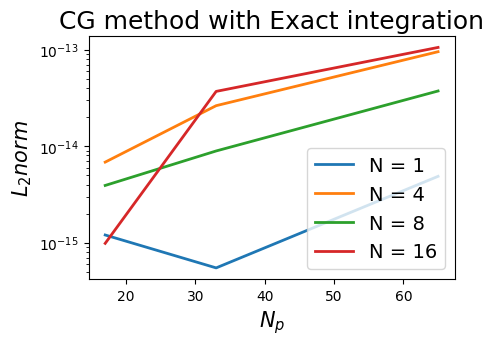

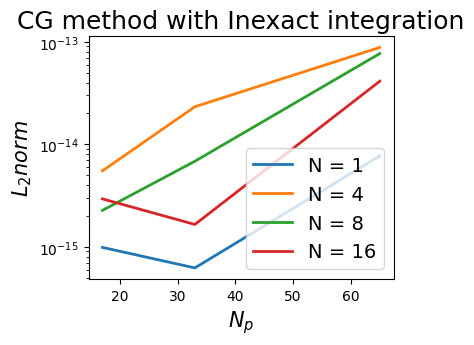

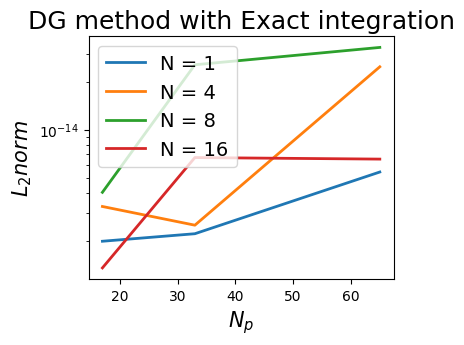

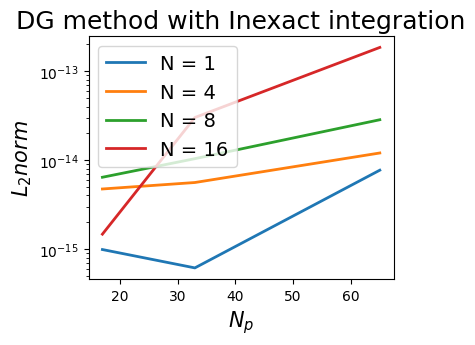

In [73]:
# Plotting L2 Norm errors for all cases
for i in range(2):
    for j in range(2):
        typetext = 'Exact' if j == 0 else 'Inexact'
        Legendtext = list()
        h = plt.figure()
        for k in range(4):
            plt.plot(Normstore[3*k:3*(k+1),1,j,i], Normstore[3*k:3*(k+1), 0,j,i], linewidth = 2)
            Legendtext.append('N = %i' % (N[k]))
        plt.title(method_types[i].upper() + ' method with ' + typetext + ' integration' , fontsize = 18)
        plt.xlabel(r'$N_p$', fontsize = 15)
        plt.ylabel(r'$L_2 norm$', fontsize = 15)
        plt.legend(Legendtext, fontsize = 14)
        plt.yscale('log')
        plt.rcParams['figure.figsize'] = [10/2.54, 8/2.54]
        plt.show()

# Discussion

Here we observe that the Laplacian operator is different for both CG and DG operations. The boundary conditions can be included within the Laplacian operator of the CG method whereas the DG method requires the construction of the entire matrix separately and solving the problem for the matrix excluding the physical domain endpoints. The errors are very low for both the cases and seem to be increasing in this given problem. Krylov methods possess higher error values, in the range of $10^{-6}$ as that is an approximate method for solving a system of equations. The error increases as the number of elements in the given parabolic profile increases and the smoothness is compromised for higher polynomial count. A sinusoidal wave was also tested and that proved to have errors decreasing to the machine precision.